# 코드 정리

In [1]:
!pip install category_encoders

# 기본 데이터 정리 및 처리
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# 전처리
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

# train, test 나누기
from sklearn.model_selection import train_test_split

import category_encoders as ce

from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('../data/bank/bank-full.csv', sep =';')


# 종속변수 y를 수치형으로 바꿔주기. no를 0(정상)으로, yes를 1(이상)로 변환
df.loc[df['y'] == 'no', 'y'] = 0
df.loc[df['y'] == 'yes', 'y'] = 1
# object 타입을 int64 타입으로 바꿔주기
df['y'] = df['y'].astype('int64')

## unknown값 처리. 사실상 Null값과 같다고 판단. 전처리 진행.
df.drop('poutcome', axis=1, inplace = True) # poutcome 변수 삭제
unknowndr1 = df[df['job'].str.contains('unknown')].index
df.drop(unknowndr1, inplace=True)
unknowndr2 = df[df['education'].str.contains('unknown')].index
df.drop(unknowndr2, inplace=True)
unknowndr3 = df[df['contact'].str.contains('unknown')].index
df.drop(unknowndr3, inplace=True)

# dur0 = df.loc[df['duration'] <= 0].index
# df.drop(dur0, inplace=True)
# bal0 = df.loc[df['balance'] < 0].index
# df.drop(bal0, inplace=True)

df.reset_index(drop=True, inplace = True) #인덱스 재 정렬

# y 변수 저장
df_labels = df['y']

#Binary Encoding
df_bi_cat = df[['month', 'job']]
df1 = ce.BinaryEncoder(cols = ['month']).fit_transform(df_bi_cat)
df2 = ce.BinaryEncoder(cols = ['job']).fit_transform(df1)

#One Hot Encoding
df_one_cat = df[['marital', 'education', 'default','housing',
       'loan', 'contact']] # month와 job을 제외한 범주형 변수 원핫인코딩

cat_pipeline = Pipeline([
    ('1hot_encoder', OneHotEncoder(sparse=False)),
    ])
df_cat_tr = cat_pipeline.fit_transform(df_one_cat)

#Robust Scaling
df_std_big_num = df[['balance', 'duration', 'pdays']] # 표준편차가 큰 수치형 변수
num_pipeline = Pipeline([
        ('rb_scaler', RobustScaler()),
    ])

df_num_tr = num_pipeline.fit_transform(df_std_big_num)

num_attribs = list(df_std_big_num) #키들(컬럼명)만 list로 반환
cat_attribs = list(df_one_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

full_df = pd.DataFrame(full_pipeline.fit_transform(df))

df_oth = df[['age', 'day', 'campaign', 'previous']] # 나머지 수치형 변수들

X = pd.concat([full_df,df2,df_oth], axis =1)
data = pd.concat([full_df,df2,df_oth, df_labels], axis =1)
data.columns

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         14,         15,         16,  'month_0',
        'month_1',  'month_2',  'month_3',    'job_0',    'job_1',    'job_2',
          'job_3',      'age',      'day', 'campaign', 'previous',        'y'],
      dtype='object')

In [3]:
# 정상/이상 구분
normal = data.loc[data['y'] == 0]
anomaly = data.loc[data['y'] == 1]

# 행 shuffle 후 위에서 4513개 --> test
normal_shuffled=normal.sample(frac=1, random_state=3).reset_index(drop=True) #shuffling
normal_shuffled_test = normal_shuffled[:4513]
normal_shuffled_train = normal_shuffled[4513:]

# train에 쓰이는 정상 데이터 X, Y 구분
X_train = normal_shuffled_train[normal_shuffled_train.columns.difference(['y'])]
Y_train = normal_shuffled_train["y"]

# test에 쓰이는 정상 데이터 X, Y 구분 (샘플링)
X_normal_shuffled_test = normal_shuffled_test[normal_shuffled_test.columns.difference(['y'])]
Y_normal_shuffled_test = normal_shuffled_test["y"]

# test에 쓰이는 이상 데이터 X, Y 구분
X_anomaly = anomaly[anomaly.columns.difference(['y'])]
y_anomaly = anomaly["y"]

X_test = pd.concat([X_normal_shuffled_test, X_anomaly])
Y_test = pd.concat([Y_normal_shuffled_test, y_anomaly])

X_train.columns

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         14,         15,         16,      'age',
       'campaign',      'day',    'job_0',    'job_1',    'job_2',    'job_3',
        'month_0',  'month_1',  'month_2',  'month_3', 'previous'],
      dtype='object')

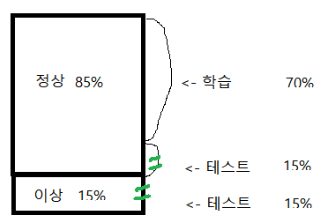

In [4]:
# 범주형 변수 따로 빼내기
cat_train = pd.concat([X_train.loc[:,3:16],X_train.loc[:,'job_0':'month_3']],axis=1)
cat_test = pd.concat([X_test.loc[:,3:16],X_test.loc[:,'job_0':'month_3']],axis=1)

# 수치형 변수만 표준화
from sklearn.preprocessing import StandardScaler
# StandardScaler 객체 생성
scaler = StandardScaler()
scale_columns = [0,1,2,'age','campaign','day', 'previous']
scaler.fit(X_train[scale_columns])

# 학습 데이터 표준화
train_scaled = scaler.transform(X_train[scale_columns])
# 테스트 데이터 표준화
test_scaled = scaler.transform(X_test[scale_columns])

# 표준화된 학습 데이터를 DataFrame으로 변환
train_scaled_df = pd.DataFrame(train_scaled, columns=scale_columns)
# 표준화된 테스트 데이터를 DataFrame으로 변환
test_scaled_df = pd.DataFrame(test_scaled, columns=scale_columns)


train_scaled_df.reset_index(drop=True,inplace=True)
cat_train.reset_index(drop=True,inplace=True)
test_scaled_df.reset_index(drop=True,inplace=True)
cat_test.reset_index(drop=True,inplace=True)

# 범주형 변수와 표준화한 수치형 변수 합치기
X_train = pd.concat([train_scaled_df,cat_train],axis=1)
X_test = pd.concat([test_scaled_df,cat_test],axis=1)

In [5]:
# 선형 상관성 존재하는 변수들 제거
X_train_lowcorr = X_train.drop([3, 5, 7, 9, 11, 13, 15, 'month_0', 'month_2'], axis=1)
X_test_lowcorr = X_test.drop([3, 5, 7, 9, 11, 13, 15, 'month_0', 'month_2'], axis=1)
X_test_lowcorr

,0,1,2,age,campaign,day,previous,4,6,8,10,12,14,16,job_0,job_1,job_2,job_3,month_1,month_3
0,1.756540,-0.246754,-0.484884,1.380191,-0.599687,1.332392,-0.335657,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1
1,1.115225,0.010338,2.576877,-0.748945,-0.599687,-0.627817,1.533653,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1,0,0,0,0
2,-0.351283,-0.828849,-0.484884,-0.942503,-0.599687,-1.117869,-0.335657,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,1,0,0,0
3,0.111978,-0.746385,-0.484884,1.864086,2.618323,1.454905,-0.335657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,0
4,-0.388836,-0.620265,-0.484884,-0.845724,-0.599687,0.229774,-0.335657,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9021,0.487508,0.398401,-0.115671,3.122212,-0.599687,0.107261,3.402963,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0
9022,-0.271645,0.815569,-0.484884,-1.523177,-0.277886,0.107261,-0.335657,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,1,1,0
9023,-0.168051,3.682387,-0.484884,0.993076,0.043915,0.107261,-0.335657,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,1,1,0
9024,0.124604,1.155125,-0.484884,2.928654,-0.277886,0.107261,-0.335657,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0


In [6]:
X_train_lowcorr.reset_index(drop=True,inplace=True)
Y_train.reset_index(drop=True,inplace=True)
X_test_lowcorr.reset_index(drop=True,inplace=True)
Y_test.reset_index(drop=True,inplace=True)

trainset = pd.concat([X_train_lowcorr,Y_train],axis = 1)
testset = pd.concat([X_test_lowcorr,Y_test],axis = 1)
dataset = pd.concat([trainset,testset],axis = 0)

In [7]:
dataset

,0,1,2,age,campaign,day,previous,4,6,8,...,12,14,16,job_0,job_1,job_2,job_3,month_1,month_3,y
0,-0.426389,1.295798,-0.484884,0.315623,-0.599687,1.087366,-0.335657,1.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
1,-0.381390,0.490566,-0.484884,0.122065,0.687517,-0.015252,-0.335657,1.0,0.0,0.0,...,0.0,0.0,0.0,0,0,1,1,0,1,0
2,-0.383009,0.039443,-0.484884,1.380191,-0.277886,-0.627817,-0.335657,1.0,0.0,1.0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
3,-0.247041,-0.072125,-0.484884,-0.361830,0.365716,0.842340,-0.335657,1.0,0.0,0.0,...,1.0,1.0,0.0,0,1,0,1,0,1,0
4,-0.293335,0.262579,2.432794,-0.652166,-0.599687,-0.872843,0.131670,1.0,0.0,0.0,...,1.0,1.0,0.0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9021,0.487508,0.398401,-0.115671,3.122212,-0.599687,0.107261,3.402963,1.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,1,1,0,1
9022,-0.271645,0.815569,-0.484884,-1.523177,-0.277886,0.107261,-0.335657,0.0,0.0,0.0,...,0.0,1.0,0.0,0,0,1,1,1,0,1
9023,-0.168051,3.682387,-0.484884,0.993076,0.043915,0.107261,-0.335657,1.0,0.0,1.0,...,0.0,0.0,0.0,0,0,1,1,1,0,1
9024,0.124604,1.155125,-0.484884,2.928654,-0.277886,0.107261,-0.335657,0.0,1.0,0.0,...,0.0,0.0,0.0,1,0,0,1,1,0,1


In [8]:
dataset.columns

Index([         0,          1,          2,      'age', 'campaign',      'day',
       'previous',          4,          6,          8,         10,         12,
               14,         16,    'job_0',    'job_1',    'job_2',    'job_3',
        'month_1',  'month_3',        'y'],
      dtype='object')

In [9]:
dataset.median()

0          -0.282005
1          -0.178843
2          -0.484884
age        -0.168272
campaign   -0.277886
day        -0.015252
previous   -0.335657
4           1.000000
6           0.000000
8           0.000000
10          0.000000
12          0.000000
14          0.000000
16          0.000000
job_0       0.000000
job_1       0.000000
job_2       0.000000
job_3       1.000000
month_1     0.000000
month_3     0.000000
y           0.000000
dtype: float64

In [10]:
dataset.describe() # 수치형 변수들 평균0, 분산1로 조정

,0,1,2,age,campaign,day,previous,4,6,8,...,12,14,16,job_0,job_1,job_2,job_3,month_1,month_3,y
count,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,...,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000,30907.000000
mean,0.026435,0.206722,0.027915,0.017439,-0.036111,-0.019263,0.042172,0.594655,0.137898,0.344291,...,0.496425,0.165658,0.087165,0.140777,0.263015,0.481218,0.639208,0.268806,0.429773,0.146019
std,1.033020,1.250456,1.015126,1.057076,0.950733,1.007883,1.264667,0.490967,0.344798,0.475144,...,0.499995,0.371780,0.282081,0.347797,0.440278,0.499655,0.480238,0.443346,0.495052,0.353131
min,-3.031142,-1.056836,-0.484884,-2.200630,-0.599687,-1.852948,-0.335657,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.409231,-0.552354,-0.484884,-0.845724,-0.599687,-0.872843,-0.335657,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.282005,-0.178843,-0.484884,-0.168272,-0.277886,-0.015252,-0.335657,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.051278,0.505119,-0.385827,0.702739,0.043915,0.597313,0.131670,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,32.626711,22.799354,7.367633,5.251349,15.168563,1.822444,128.179420,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# dataset.to_csv("preprocessing_modify.csv", index = False)
# trainset.to_csv("train_set.csv", index = False)
# testset.to_csv("test_set.csv", index = False)

In [12]:
#정상 데이터의 변수별 분포 확인

# for col in dataset.columns:
#     sns.distplot(Normal.loc[Normal[col].notnull(), col])
#     plt.title(col)
#     plt.show()

In [13]:
#이상 데이터의 변수별 분포 확인

# for col in dataset.columns:
#     sns.distplot(Anomaly.loc[Anomaly[col].notnull(), col])
#     plt.title(col)
#     plt.show()